# Fit-Umgebung für Python mit kafe2

Wir wollen hier an dieser Stelle ein wichtiges Tool vorstellen, mit denen Sie Daten an sog. Datenmodelle anpassen `fitten` können. In Python gibt es mehrere Implementationen von `Fit`-Funktionen, z.B. `curve_fit` aus dem Modul `scipy` oder das hier vorgestellte `kafe2`-Modul.

Das Modul `kafe2` [**Ka**rlsruhe **F**it **E**nvironment **2**](https://kafe2.readthedocs.io/en/latest/) ist speziell für Praktikumsauswertungen entwickelt worden, es basiert jedoch auf Algorithmen, die in der Physik weitverbreitet sind (`Minuit`). Ein Vorteil von `kafe2` gegenüber `curve_fit` ist das bessere Handling von Fehlern und hat eine eingebaute Visualisierung der Fit-Ergebnisse. 

Die Arbeitsweise von `kafe2` werden wir anhand von Beispielen erklären.

## Konzeptueller Aufbau von kafe2

Struktur von KaFE 2:

<img src="figs/kafe2_structure.png" style="width: 50%;" />

Die wichtigsten Komponenten für die Nutzung sind die Beschreibung der Daten (Dataset), die Model-Funktion, der Minimizer hier als die zentrale Fit-Komponente und dann am Ende zum Bewerten der Ergebnisse, ein Report und Plots.

## Das klassische Beispiel - ein Geradenfit

Nehmen wir ein klassisches Beispiel, in dem wir Datenpunkte $x$ und $y$ an eine Gerade anfitten werden. Die Datenpunkte sollen nicht miteinander korreliert sein.

Dazu definieren wir jeweils ein Array für $x$ und $y$ und für die $y$-Werte jeweils die indivduellen Varianzen. Wir wollen gleich am Anfang Fehler mit definieren, wobei wir in den Beispielen einmal einen allg. Fehler und dann die individuellen Fehler durchspielen wollen.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x_data = np.array([1.0, 2.0, 3.0, 4.0])
y_data = np.array([2.3, 4.2, 7.5, 9.4])
y_err  = np.array([0.3,0.45,0.35,0.25])

Text(0.5, 1.0, 'Data points')

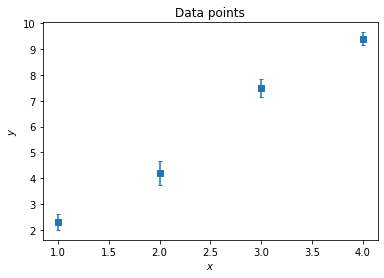

In [45]:
# Fehlerbalkenplot

fig, ax = plt.subplots()

ax.errorbar(x_data, y_data, yerr=y_err, capsize=2., linestyle='', marker='s')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title('Data points')

## Workflow für das Fitten mit `kafe2`

### 1. Datensatz beschreiben

In diesem Beispiel geht es um Daten in $x$ und $y$, deswegen müssen aus der `kafe2`-Bibliothek die entsprechenden Funktionen bekannt gemacht werden:

In [2]:
from kafe2 import XYContainer, Fit, Plot, ContoursProfiler  # einige Funktionen bekannt machen

Die Daten werden nun beschrieben:

In [46]:
xy_data = XYContainer(x_data=x_data, y_data=y_data)

Nun werden zu den Daten, die gewichteten Fehler hinzugefügt. Statt den gewichteten Fehlern gibt es noch die Möglichkeit einen absoluten Fehler oder einen relativen Fehler für alle Datenpunkte anzugeben:

In [47]:
xy_data.add_error(axis='y', err_val= y_err)              # gewichteter Fehler
#xy_data.add_error(axis='y', err_val=0.3)                 # absoluter Fehler für alle Datenpunkte
#xy_data.add_error(axis='y', err_val=0.15, relative=True) # relativer Fehler für alle Datenpunkte 

'xRSH6n1f'

### 2. Fitten

Im nächsten Schritt wird das Fitten vorbereitet. Jeder Datenanpassung liegt ein sog. Datenmodell oder eine Datenfunktion zu Grunde. Diese Funktion hat mind. einen Parameter, der variiert werden muss, damit die Funktion optimal an die Datenpunkte angepasst werden kann. Die Funktion kann einfach in Python definiert werden:

In [48]:
def linear_model(x, a, b):
    # Our first model is a simple linear function
    return a * x + b

Wichtig bei diesen Funktionen:
 * der erste Parameter sollte ein $x$ sein
 * die Funktion sollte mit einfachen Werten für $x$ aber auch Arrays aufrufbar sein. 
 * die weiteren Parameter $a$, $b$, ... sind die sog. Fit-Parameter und sind einfache Werte
 
Zum Verständnis, wie `linear_model` genutzt werden kann:

4


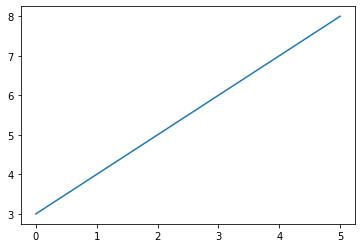

In [49]:
a = 1
b = 3
print(linear_model(1,a,b))  # der Wert für x=1

x = np.linspace(0,5,100)    # ein Array für x
y = linear_model(x, a, b)   # die Funktionswerte

fig, ax = plt.subplots()
ax.plot(x, y)

Die Funktion `linear_model` muss nun `kafe2` zum Fitten gegeben werden. Dazu erzeugt man ein Fit-Objekt, mit den Daten und der Datenfunktion:

In [50]:
my_fit = Fit(data=xy_data, model_function=linear_model)  # das ist die allg. Funktion, XYFit geht auch!

Dann wird das Fitten durchgeführt:

In [51]:
results = my_fit.do_fit()   # los geht's!

### 3. Ergebnisse

Wenn alles geklappt hat, kann man sich einen Report über das Resultat anschauen:

In [52]:
my_fit.report()
# my_fit.report(show_data=False)    # zeige nicht die Daten

########
# Data #
########

    X Data
    1.0   
    2.0   
    3.0   
    4.0   

    Y Data  Y Data Error  Y Data Correlation Matrix
    ======  ============  =========================
    2.3     0.3           [1. 0. 0. 0.]            
    4.2     0.45          [0. 1. 0. 0.]            
    7.5     0.35          [0. 0. 1. 0.]            
    9.4     0.25          [0. 0. 0. 1.]            

#########
# Model #
#########

    Model Function

        linear_model(x; a, b)

    X Model
    1.0    
    2.0    
    3.0    
    4.0    

    Y Model
    2.262  
    4.673  
    7.083  
    9.493  

###############
# Fit Results #
###############

    Model Parameters

        a = 2.41 +/- 0.13
        b = -0.15 +/- 0.38

    Model Parameter Correlations

           a        b      
           =======  =======
        a  1.0      -0.9095
        b  -0.9095  1.0    

    Cost Function

        cost function: chi-square (with covariance matrix)

        cost / ndf = 2.678 / 2 = 1.339

        

Besser ist allerdings, wenn man man sich die Ergebnisse selber anschaut. Das Ergebnis von `do_fit` ist ein Python Dictionary:

In [53]:
print(results)

{'did_fit': True, 'cost': 2.6779212418183818, 'ndf': 2, 'goodness_of_fit': 2.6779212418183818, 'cost/ndf': 1.3389606209091909, 'chi2_probability': 0.2621179669793847, 'parameter_values': OrderedDict([('a', 2.410372330912922), ('b', -0.14822776208071486)]), 'parameter_cov_mat': array([[ 0.01605522, -0.04370975],
       [-0.04370975,  0.14386601]]), 'parameter_errors': OrderedDict([('a', 0.1267089696080867), ('b', 0.37929611386007195)]), 'parameter_cor_mat': array([[ 1.        , -0.90947877],
       [-0.90947877,  1.        ]]), 'asymmetric_parameter_errors': None}


In [55]:
if results['did_fit']:    # erfolgreich?
    a = results['parameter_values']['a']
    b = results['parameter_values']['b']
    a_err = results['parameter_errors']['a']
    b_err = results['parameter_errors']['b']

    # man kann den Fehler auch aus der Covarianz-Matrix ableiten
    cov = results['parameter_cov_mat']

    print(f'a= {a:.2f} +/- {a_err:.2f} (cov_error={np.sqrt(cov[0,0]):.2f})')
    print(f'b= {b:.2f} +/- {b_err:.2f} (cov_error={np.sqrt(cov[1,1]):.2f})')
    rho = cov[1,0] / np.sqrt(cov[0,0] * cov[1,1])
    print(f'Correlation coefficient {rho:.3f}')

    # Bewertung des Fits mittels des Chi-Square/ndf-Wertes
    chi_square = results['cost'] 
    ndf = results['ndf'] 
    chi_square_ndf = results['cost/ndf'] 
    print(f'chi_square/ndf = {chi_square:.1f}/{ndf} = {chi_square_ndf:.2f}')
else:
    print('Fit failed')

a= 2.41 +/- 0.13 (cov_error=0.13)
b= -0.15 +/- 0.38 (cov_error=0.38)
Correlation coefficient -0.909
chi_square/ndf = 2.7/2 = 1.34


### 4. Kontrol-Plots

`kafe2` bietet die Möglichkeit, das Fit-Ergebnis direkt zu plotten. Dieser Plot enthält alle wichtigen Daten und Ergebnisse zum Fit-Prozess:

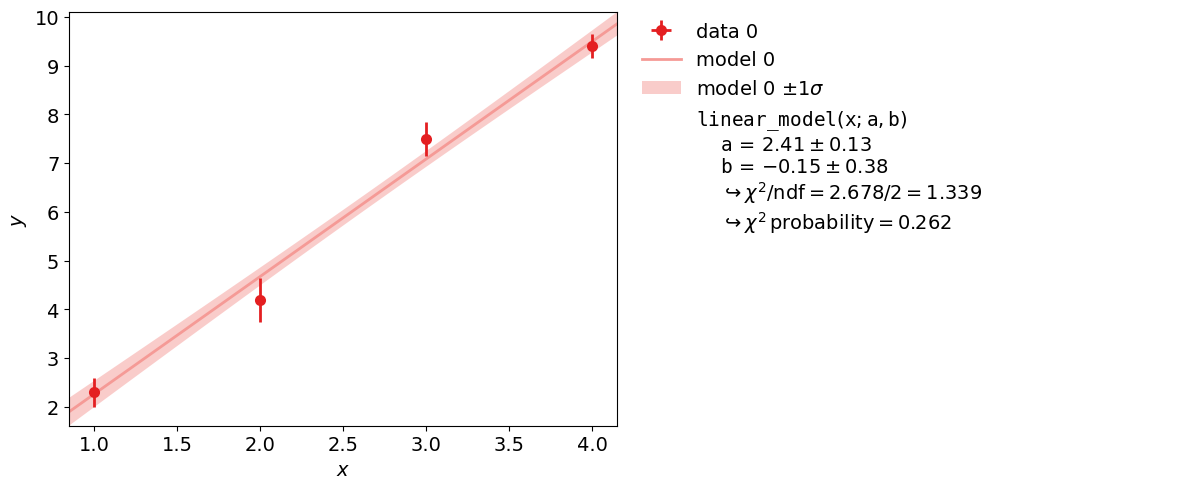

In [56]:
if results['did_fit']:
    plot = Plot([my_fit])  # erzeuge ein Plot-Objekt
    _ = plot.plot()

Daneben lässt sich mit den Ergebnissen auch selber ein Plot erzeugen:

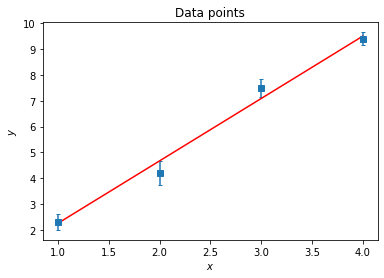

In [57]:
if results['did_fit']:
    fig, ax = plt.subplots()

    a = results['parameter_values']['a']
    b = results['parameter_values']['b']
    a_err = results['parameter_errors']['a']
    b_err = results['parameter_errors']['b']

    # berechne die Werte aus dem Modell
    y_data_fit = linear_model(x_data, a, b)

    ax.errorbar(x_data, y_data, yerr=y_err, capsize=2., linestyle='', marker='s')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title('Data points')
    
    # plot den Geradenfit  
    ax.plot(x_data, y_data_fit, 'r-')   # nicht so schön wie bei dem Kontrolplot!
    
    #print(x_data)
    #print(y_data)
    #print(y_data_fit)

## Gleiches Beispiel nur mit einer anderen Fit-Funktion

Man kann natürlich versuchen, an die Datenpunkte eine andere Funktion anzupassen, z.B. eine Parabel:

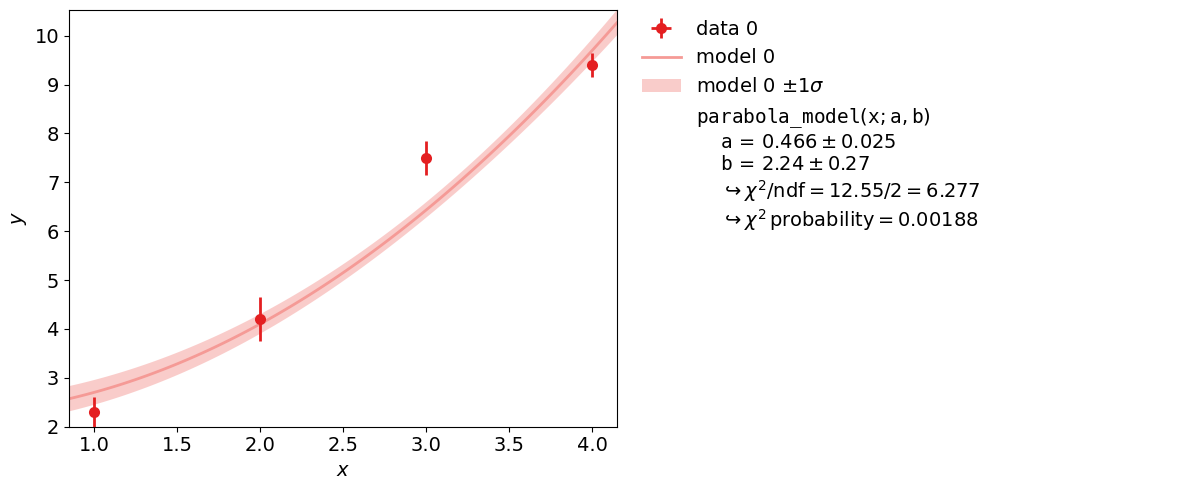

In [58]:
def parabola_model(x, a, b):
    return a*x**2+b

my_fit2 = Fit(data=xy_data, model_function=parabola_model)
results2 = my_fit2.do_fit()

if results2['did_fit']:
    plot2 = Plot([my_fit2])  # erzeuge ein Plot-Objekt
    plot2.plot()

*Wichtig:* Die Resultate für die Parameter beim Fitten sehen erstmal gut aus, aber das $\chi^2/\textrm{ndf}$ ist erheblich $>1$. Insofern ist der Fit nicht so gelungen!

## Ein Fit-Beispiel, mit $x$- und $y$-Fehlern

Aus vielen Experimenten werden Sie Daten erhalten, die nicht nur die $y$-Werte fehlerbehaftet sind, sondern wo auch der $x$-Wert einen Fehler hat. Diese Daten können mit `kafe2` auch einfach gefittet werden. Schauen wir uns erstmal die Daten an:

<ErrorbarContainer object of 3 artists>

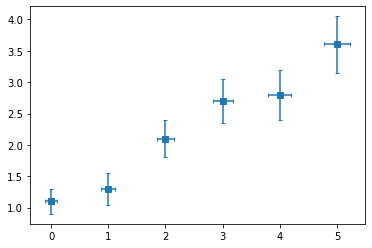

In [59]:
data = np.loadtxt('data/dataxy.txt')

x_data = data[:,0]
x_err = data[:,1]
y_data = data[:,2]
y_err = data[:,3]

fig, ax =  plt.subplots()

ax.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, capsize=2., linestyle='', marker='s')

Dazu verwenden wir wieder den `XYContainer`  und fügen nun auch einen $x$-Fehler hinzu. Wieder nehmen wir an, dass die $x$- und $y$-Werte nicht korreliert sind:

In [60]:
xy_data = XYContainer(x_data=x_data, y_data=y_data)
xy_data.add_error(axis='x', err_val= x_err) 
xy_data.add_error(axis='y', err_val= y_err) 

'cZFVsjsx'

Dann wird wieder eine Model-Funktion definiert und dann der Fit durchgeführt:

In [61]:
def linear_model(x, a, b):
    # Our first model is a simple linear function
    return a * x + b

xy_fit = Fit(data=xy_data, model_function=linear_model) 
xy_results = xy_fit.do_fit()

Sie können wieder die gleichen Reports und Plots zur Bewertung erstellen:

########
# Data #
########

    X Data  X Data Error  X Data Correlation Matrix
    ======  ============  =========================
    0.0     0.1           [1. 0. 0. 0. 0. 0.]      
    1.0     0.125         [0. 1. 0. 0. 0. 0.]      
    2.0     0.15          [0. 0. 1. 0. 0. 0.]      
    3.0     0.175         [0. 0. 0. 1. 0. 0.]      
    4.0     0.2           [0. 0. 0. 0. 1. 0.]      
    5.0     0.225         [0. 0. 0. 0. 0. 1.]      

    Y Data  Y Data Error  Y Data Correlation Matrix
    ======  ============  =========================
    1.1     0.2           [1. 0. 0. 0. 0. 0.]      
    1.3     0.25          [0. 1. 0. 0. 0. 0.]      
    2.1     0.3           [0. 0. 1. 0. 0. 0.]      
    2.7     0.35          [0. 0. 0. 1. 0. 0.]      
    2.8     0.4           [0. 0. 0. 0. 1. 0.]      
    3.6     0.45          [0. 0. 0. 0. 0. 1.]      

#########
# Model #
#########

    Model Function

        linear_model(x; a, b)

    X Model
    0.0    
    1.0    
    2.0    
    3.0 

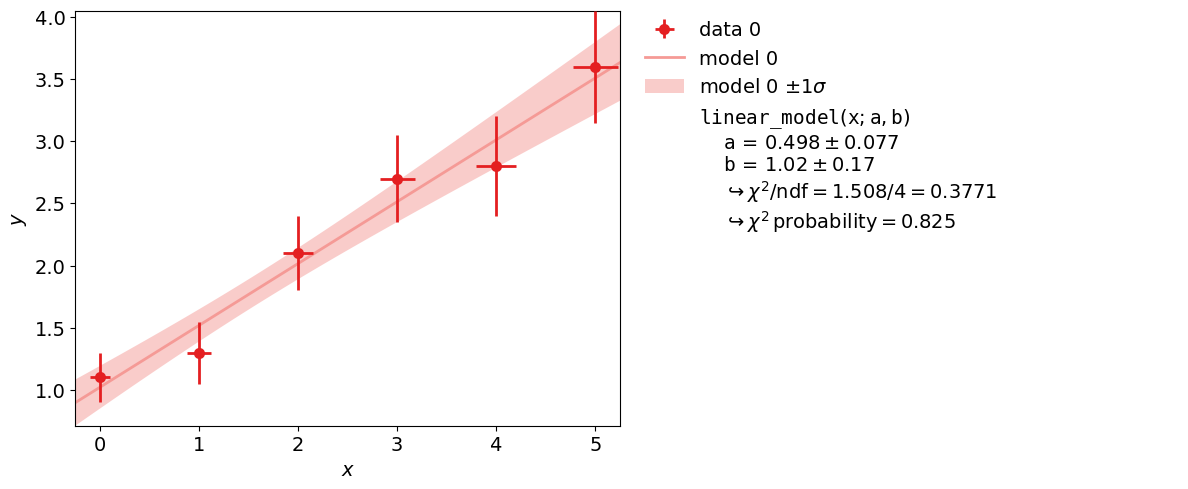

In [62]:
xy_fit.report()

if xy_results['did_fit']:
    xy_plot = Plot([xy_fit])  # erzeuge ein Plot-Objekt
    xy_plot.plot()

## Ein weiteres Beispiel ein Gauss-Fit

Ein Beispiel für eine komplexere Funktion soll nun das Fitten einer Gauss-Funktion sein.

<ErrorbarContainer object of 3 artists>

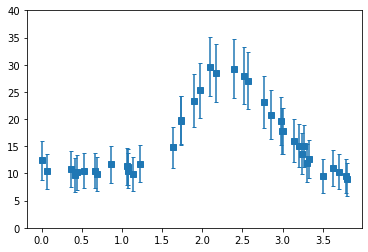

In [9]:
data = np.loadtxt('data/gauss_data.dat')

x_data = data[:,0]
y_data = data[:,1]
y_err  = data[:,2]


fig, ax = plt.subplots()

ax.set_ylim(0,40)
ax.errorbar(x_data, y_data, yerr=y_err, capsize=2., linestyle='', marker='s')

Die Daten werden wie üblich zum Fitten vorbereitet:

In [10]:
xy_data = XYContainer(x_data=x_data, y_data=y_data)
xy_data.add_error(axis='y', err_val= y_err) 

'qIxtyu55'

Gaussfits haben in der Regel das Problem, dass der Fit-Algorithmus nicht immer den Gauss *erkennen* kann. Deswegen kann man in der Model-Funktion, sog. Anfangsparameter einsetzen, die den wahren Werte nahe kommen sollen:

In [11]:
def gauss_model(x, a=20., x0=2.25, sigma=.5, b=10.):
    # define a standard gauss function
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b

xy_fit = Fit(data=xy_data, model_function=gauss_model) 
xy_results = xy_fit.do_fit()

a     = 19.80 +/- 2.43
x0    = 2.34 +/- 0.05
sigma = 0.48 +/- 0.06
b     = 10.17 +/- 0.86
chi_square/ndf = 2.6/36 = 0.07


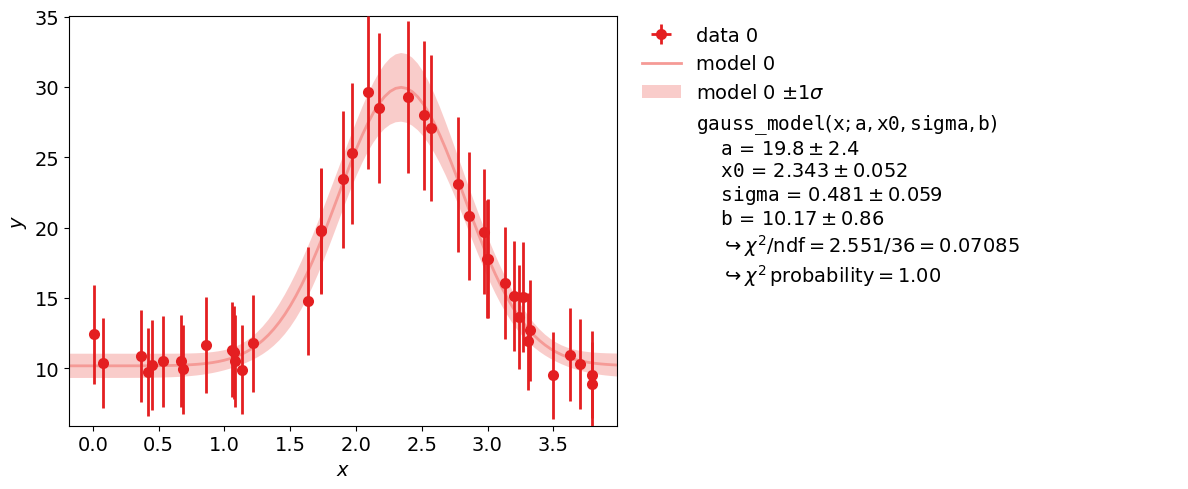

In [12]:
if xy_results['did_fit']:    # erfolgreich?
    a = xy_results['parameter_values']['a']
    x0 = xy_results['parameter_values']['x0']
    sigma = xy_results['parameter_values']['sigma']
    b =  xy_results['parameter_values']['b']
    a_err = xy_results['parameter_errors']['a']
    x0_err = xy_results['parameter_errors']['x0']
    sigma_err = xy_results['parameter_errors']['sigma']
    b_err = xy_results['parameter_errors']['b']

    print(f'a     = {a:.2f} +/- {a_err:.2f}')
    print(f'x0    = {x0:.2f} +/- {x0_err:.2f}')
    print(f'sigma = {sigma:.2f} +/- {sigma_err:.2f}')
    print(f'b     = {b:.2f} +/- {b_err:.2f}')

    # Bewertung des Fits mittels des Chi-Square/ndf-Wertes
    chi_square = xy_results['cost'] 
    ndf = xy_results['ndf'] 
    chi_square_ndf = xy_results['cost/ndf'] 
    print(f'chi_square/ndf = {chi_square:.1f}/{ndf} = {chi_square_ndf:.2f}')
    
    xy_plot = Plot([xy_fit])  # erzeuge ein Plot-Objekt
    xy_plot.plot()
else:
    print('Fit failed')
        
#xy_fit.report(show_data=False)